<a href="https://colab.research.google.com/github/emiliocicese/CDSI_2023/blob/main/CDSI_2023/Practica_2/Tarea_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Tarea 2**

Emilio Hernández Arellano

Ciencia de Datos



In [ ]:
!pip install mediapipe #Instalación de mediapipe en caso de ser necesario

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 14.5 MB/s eta 0:00:00


In [95]:
#Importando librerías
import os
import glob
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, GridSearchCV

In [86]:
def obtain_features(file,index = [],normalized = True):
  #Obteniendo modelo de mediapipe:
  mp_drawing = mp.solutions.drawing_utils
  mp_hands = mp.solutions.hands
  hands = mp_hands.Hands(static_image_mode=True,
    max_num_hands=1, min_detection_confidence=0.7)
  img_read = cv2.imread(file)
  height, width, _ = img_read.shape
  img_read = cv2.flip(img_read,1)
  img_rgb = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
  results = hands.process(img_rgb)
  hands.close()
  x,y = [],[]
  if results.multi_hand_landmarks is not None:
    for hand_landmarks in results.multi_hand_landmarks:
        for (i, points) in enumerate(hand_landmarks.landmark):
          if index == []:
            x1 = points.x
            y1 = points.y
            x1 = int(x1*height) if normalized == False else x1
            y1 = int(y1*width) if normalized == False else y1
            x.append(x1); y.append(y1)
          else: #Esto unicamente servirá si se quieren algunos puntos 
          #específicos, de modo que se debe comparar que i estén en index
          #por lo demás es igual, se obtienen las coordenadas x,y y se concatentan
            if i in index:
              x1 = points.x
              y1 = points.y
              x1 = int(x1*height) if normalized == False else x1
              y1 = int(y1*width) if normalized == False else y1
              x.append(x1); y.append(y1)
    point_21 = np.array(list(zip(x,y)))
    return point_21.flatten()

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
def load_data(path=""):
  features = []
  labels = []
  groups = [] #Representa al número de sujetos, de modo que s asegura que
  # a parte del etiquetado de las clases, tambien se etiquetará los grupos
  if path:
    for file in glob.glob(path):
      base_name = os.path.basename(file)
      letter = base_name.split("-")[0]
      #print(file)
      #labels.append(letter)
      feature = obtain_features(file)
      if feature is not None:
        labels.append(letter)
        features.append(feature)
    features_array = np.array(features)
    return labels,features_array
  else:
    for i in range (1,11):
      """
      Con este for se garantiza contar el número de archivos por sujeto que no 
      esén corrompidos, es decir que solo se contarán aquellos que no regresan NONE
      """
      path1 = "/content/drive/MyDrive/CDSI/Practica_2/Dataset sensores/S"+str(i)+"/*/*.jpg"
      j = 0
      for file in glob.glob(path1):
        base_name = os.path.basename(file)
        letter = base_name.split("-")[0]
        feature = obtain_features(file)
        if feature is not None:
          labels.append(letter)
          features.append(feature)
          j+=1
      n = (np.ones(j)*i).tolist()
      groups.extend(n)
      features_array = np.array(features)
    return labels,features_array,groups


# Visualizando características en una sola imagen

Para ello se ocupará la libería Media Pipe

In [81]:
#Código para la detección de los 21 puntos

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,
    max_num_hands=1, min_detection_confidence=0.7)

In [82]:
#Visualizando para una mano
file_test = "/content/drive/MyDrive/CDSI/Practica_2/Dataset sensores/S1/O/O-3-56.jpg"
img = cv2.imread(file_test)
img1 = img
height, width, _ = img.shape
print("La altura de la imagen es: " + str(height)
     + " con un ancho de: " + str(width))
img = cv2.flip(img,1)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = hands.process(img_rgb)

La altura de la imagen es: 360 con un ancho de: 360


In [83]:
"""
Al estar la imagen reflejada, aparece como mano izquiera
"""

#Observando resultados
print('Handedness:', results.multi_handedness)

Handedness: [classification {
  index: 0
  score: 0.9959268569946289
  label: "Left"
}
]


Imagen original


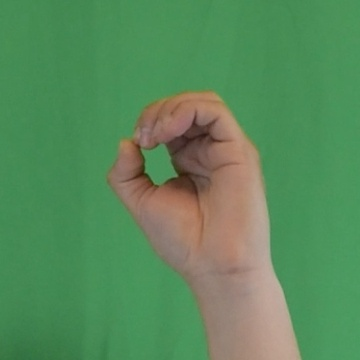

In [84]:
print("Imagen original")
cv2_imshow(img1)

Nueva imagen con puntos detectados


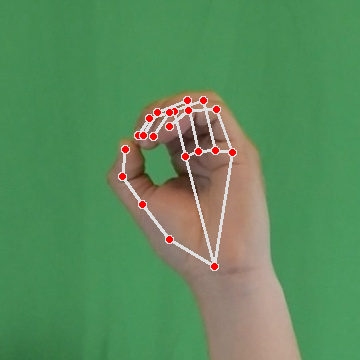

In [85]:
if results.multi_hand_landmarks is not None:
  for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            img, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        
img = cv2.flip(img,1)
print("Nueva imagen con puntos detectados")
cv2_imshow(img)
hands.close()

In [79]:
path = "/content/drive/MyDrive/CDSI/Practica_2/Dataset sensores/S1/O/O-1-43.jpg"
r = obtain_features(path, normalized = False)
r1 = pd.DataFrame(r)
print(r1.T)

    0    1    2    3    4    5    6    7    8    9   ...   32   33   34   35  \
0  200  261  161  228  137  188  122  157  127  130  ...  159  117  235  149   

    36   37   38   39   40   41  
0  228  108  200  101  179  112  

[1 rows x 42 columns]


In [87]:
#Extrayendo todas las características de los datasets
l1,f1,g1 = load_data()

In [89]:
print("Se descartaron "+str(500-len(g1))
+ " obteniendo un total de "+str(len(g1))+" muestras")

Se descartaron 27 obteniendo un total de 473 muestras


# Implementando modelo

In [90]:
#Realizando scores de validación cruzada mediante la estrategia de LeaveOneGrouOut
"""
Esto debido a que en el leaveoneout haría 477 iteraciones, por lo que se prefiere 
este enfoque para solo hacer 10 iteraciones pertenecientes a los 10 sujetos
"""
X = f1
y = np.array(l1)
groups = g1
scores = []
logo = LeaveOneGroupOut()
forest = RandomForestClassifier()



#Una vez definidas las variables se aplica cross validation

for train_index, test_index in logo.split(X, y, groups):
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    forest.fit(X_train,y_train)
    score = forest.score(X_test,y_test)
    scores.append(score)

# Imprimir resultados
print("Con el modelo de Random Forest se tiene un accuracy de %0.2f y una std: %0.2f" 
% (np.mean(scores), np.std(scores) * 2))

Con el modelo de Random Forest se tiene un accuracy de 0.94 y una std: 0.09


In [91]:
from sklearn import svm

sv = svm.SVC()
for train_index, test_index in logo.split(X, y, groups):
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    sv.fit(X_train,y_train)
    score = sv.score(X_test,y_test)
    scores.append(score)

# Imprimir resultados
print("Con el modelo de SVM se tiene un accuracy de %0.2f y una std: %0.2f" 
% (np.mean(scores), np.std(scores) * 2))

Con el modelo de SVM se tiene un accuracy de 0.95 y una std: 0.08


In [92]:

#Aplicando enfoque Greedy para ajuste de hiperparámetros del svm

param_grid_svm = {'C': [0.1, 1, 10],
                  'gamma': ['scale', 'auto']} #hiperparametros del svm

sv = svm.SVC(random_state=42)
grid_search_svm = GridSearchCV(sv,param_grid=param_grid_svm,cv=logo,n_jobs=-1)

#Ajustando el modelo a los datos de entrenamiento
grid_search_svm.fit(X=X,y=y,groups=groups)
best_svm = grid_search_svm.best_estimator_
print("Mejores parámetros encontrados: ", grid_search_svm.best_params_)
print("Precisión media en validación cruzada: ", grid_search_svm.best_score_)

Mejores parámetros encontrados:  {'C': 10, 'gamma': 'scale'}
Precisión media en validación cruzada:  0.9735032928064842


In [93]:
#Aplicando enfoque Greedy para ajuste de hiperparámetros del Random Forest

param_grid_rf = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20]} #hiperparametros del Random Forest

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf,param_grid=param_grid_rf,cv=logo,n_jobs=-1)

#Ajustando el modelo a los datos de entrenamiento
grid_search_rf.fit(X=X,y=y,groups=groups)
best_forest = grid_search_rf.best_estimator_
print("Mejores parámetros encontrados: ", grid_search_rf.best_params_)
print("Precisión media en validación cruzada: ", grid_search_rf.best_score_)

Mejores parámetros encontrados:  {'max_depth': None, 'n_estimators': 300}
Precisión media en validación cruzada:  0.9457916831857627


#Evaluado con Dataset propia

In [128]:
path = "/content/drive/MyDrive/CDSI/Practica_2/Dataset_propia/*.jpg"
l2,f2 = load_data(path=path)

## SVM

              precision    recall  f1-score   support

           A       1.00      0.50      0.67         2
           E       1.00      0.67      0.80         3
           I       1.00      0.50      0.67         2
           O       0.40      1.00      0.57         2
           U       1.00      1.00      1.00         2

    accuracy                           0.73        11
   macro avg       0.88      0.73      0.74        11
weighted avg       0.89      0.73      0.75        11



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


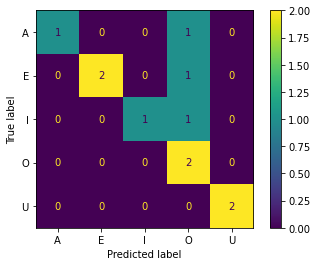

In [129]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
#Evaluando Matriz de Confusión con SVM
plot_confusion_matrix(grid_search_svm,f2,l2)
l2_pred = grid_search_svm.predict(f2)
print(metrics.classification_report(l2,l2_pred))

              precision    recall  f1-score   support

           A       1.00      0.50      0.67         2
           E       0.67      0.67      0.67         3
           I       1.00      0.50      0.67         2
           O       0.25      0.50      0.33         2
           U       1.00      1.00      1.00         2

    accuracy                           0.64        11
   macro avg       0.78      0.63      0.67        11
weighted avg       0.77      0.64      0.67        11



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


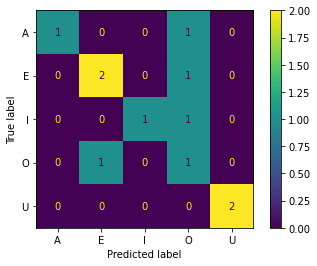

In [130]:

sv.fit(f1,l1) #Modelo genérico creado para la aplicación del greedy
plot_confusion_matrix(sv,f2,l2)
l2_pred = sv.predict(f2)
print(metrics.classification_report(l2,l2_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           A       1.00      0.50      0.67         2
           E       0.50      0.33      0.40         3
           I       1.00      1.00      1.00         2
           O       0.25      0.50      0.33         2
           U       1.00      1.00      1.00         2

    accuracy                           0.64        11
   macro avg       0.75      0.67      0.68        11
weighted avg       0.73      0.64      0.65        11



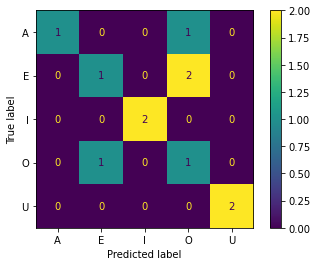

In [131]:
#Evaluando con Random Forest y enfoque Greedy

plot_confusion_matrix(grid_search_rf,f2,l2)
l2_pred = grid_search_rf.predict(f2)
print(metrics.classification_report(l2,l2_pred))

## Random Forest

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           A       0.50      0.50      0.50         2
           E       0.00      0.00      0.00         2
           I       1.00      1.00      1.00         2
           O       0.33      0.50      0.40         2
           U       1.00      1.00      1.00         2

    accuracy                           0.60        10
   macro avg       0.57      0.60      0.58        10
weighted avg       0.57      0.60      0.58        10



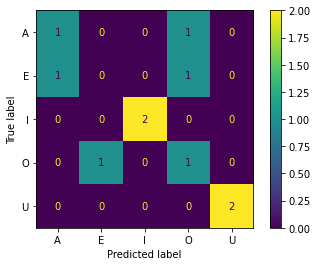

In [127]:
#Aplicando Random Forest sin Greedy

rf.fit(f1,l1) #Modelo genérico creado para la aplicación del greedy
plot_confusion_matrix(rf,f2,l2)
l2_pred = rf.predict(f2)
print(metrics.classification_report(l2,l2_pred))